In [1]:
import os, sys
sys.path.append("/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/NeuralOptimalTransport-main/")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/Users/shizhouxu/Desktop/SX_Workspace/WHOMP_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
cd"/Users/shizhouxu/Desktop/SX_Workspace"

/Users/shizhouxu/Desktop/SX_Workspace


/Users/shizhouxu/Desktop/SX_Workspace/WHOMP_venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
DEVICE_IDS = [0]

#DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
#DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

DATASET1, DATASET1_PATH, ATTRIBUTE1, ATTR_VALUE1 = 'celeba', '/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/celeba_raw_data/celeba', 'Smiling', 1
DATASET2, DATASET2_PATH, ATTRIBUTE2, ATTR_VALUE2 = 'celeba', '/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/celeba_raw_data/celeba', 'Smiling', -1

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 64

PLOT_INTERVAL = 1000
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 6400
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{ATTRIBUTE1}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, ATTRIBUTE1, IMG_SIZE)

config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
mps_device = torch.device("mps")
torch.manual_seed(SEED); np.random.seed(SEED)

output_path_T = "/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_T/"
output_path_f = "/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_f/"

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

"""filename = '/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/NeuralOptimalTransport-main/{}_{}_test.json'.format(DATASET1, ATTR_VALUE1)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats"""

X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE, attribute=ATTRIBUTE1, attribute_value=ATTR_VALUE1)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE, attribute=ATTRIBUTE2, attribute_value=ATTR_VALUE2)
    
torch.mps.empty_cache(); gc.collect()

f = ResNet_D(IMG_SIZE, nc=3).to(mps_device)
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).to(mps_device)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))



T params: 9715827
f params: 22933441


In [12]:
T.load_state_dict(torch.load('/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_T/T_Smiling_6399.pt', map_location=torch.device('mps')))
f.load_state_dict(torch.load('/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_f/f_Smiling_6399.pt', map_location=torch.device('mps')))

/var/folders/w_/6kbmt3694cl2m4jh53msnwbh0000gn/T/ipykernel_34418/588100621.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  T.load_state_dict(torch.load('/Users/shizhouxu

<All keys matched successfully>

In [5]:
wandb.init(name=EXP_NAME, config=config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shzxu (shizhou). Use `wandb login --relogin` to force relogin


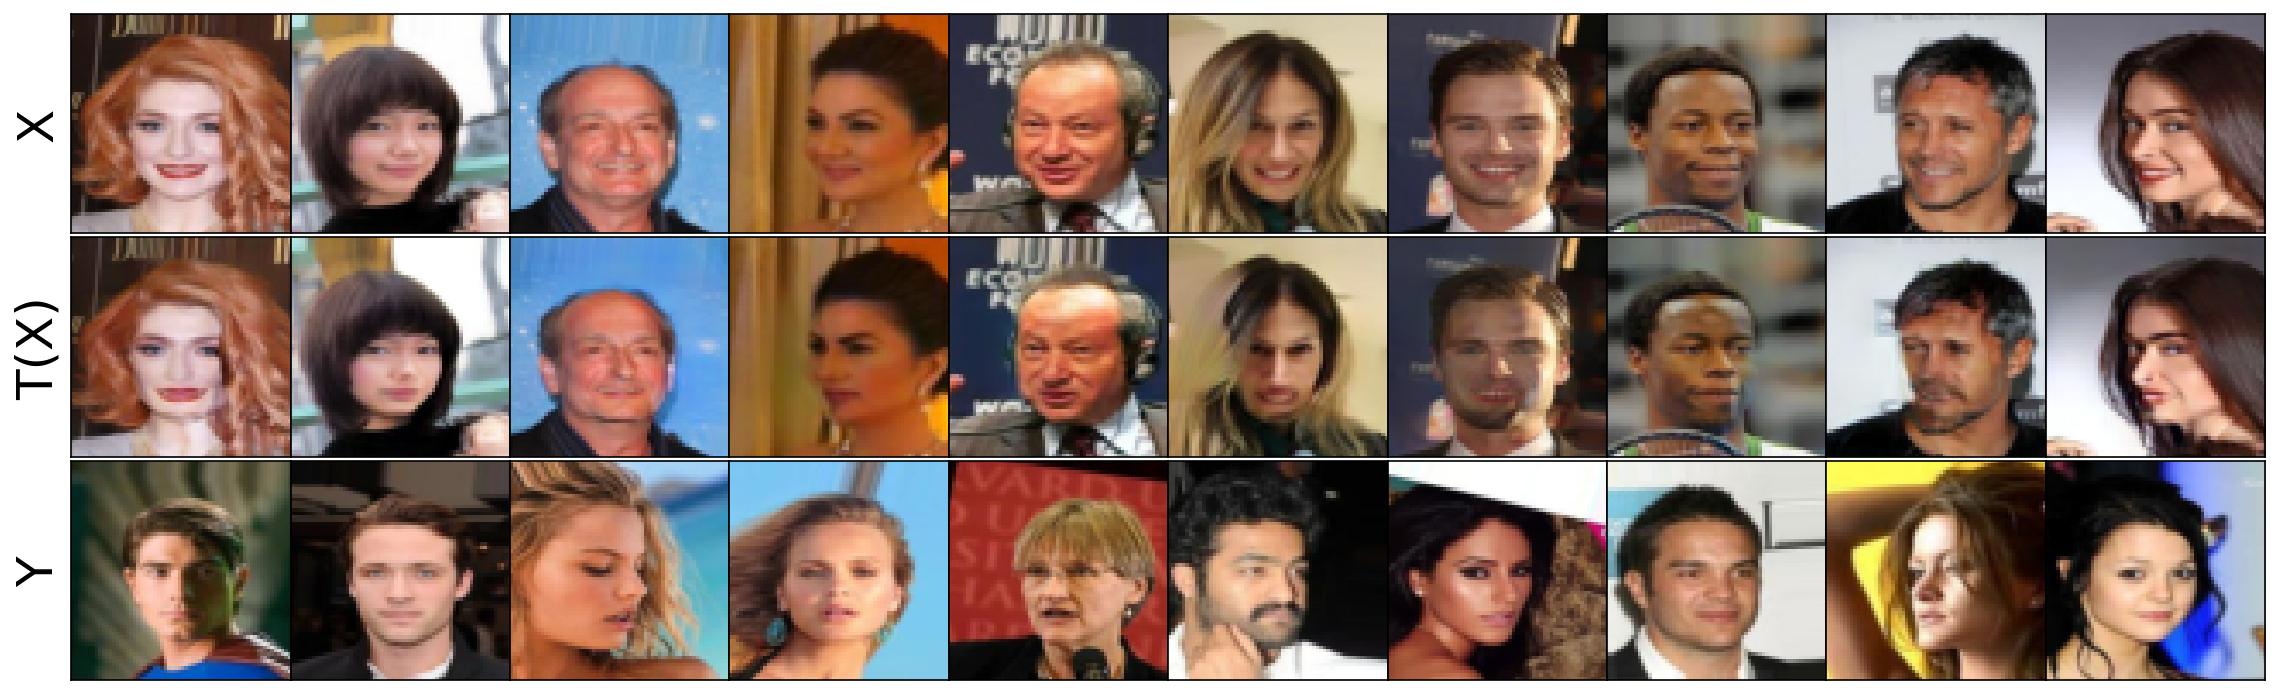

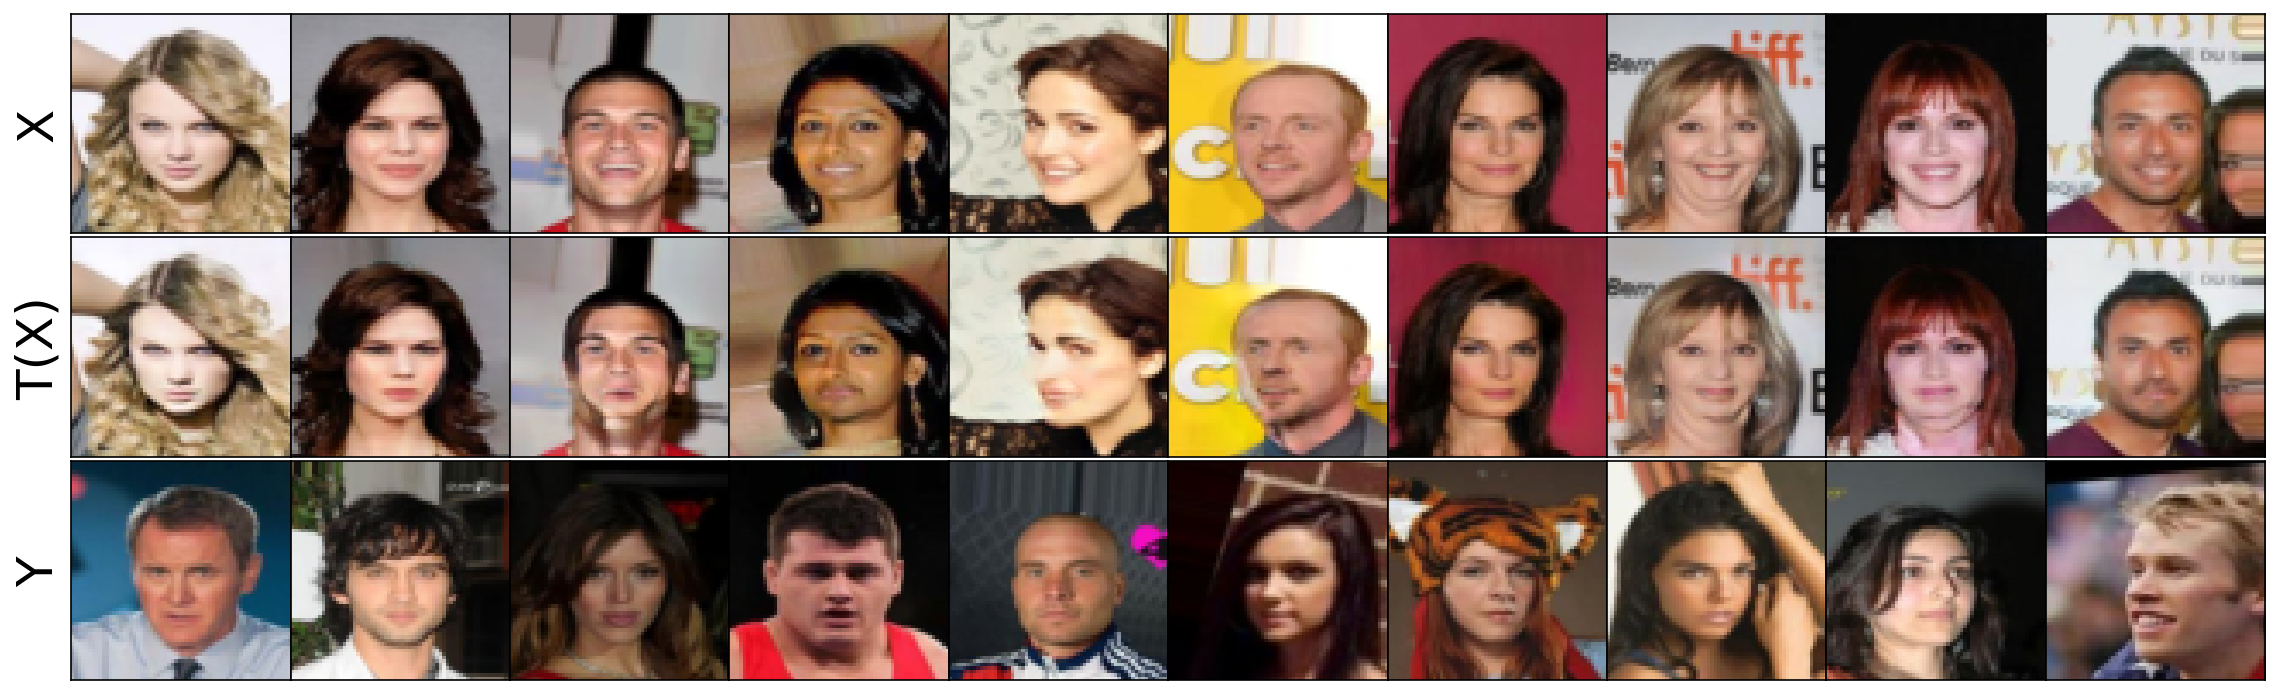

In [6]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.mps.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.mps.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        """fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) """
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        """fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) """
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    '''if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma'''
        
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:

        torch.save(T.state_dict(), os.path.join(output_path_T, f'T_{ATTRIBUTE1}_{step+6399}.pt'))
        torch.save(f.state_dict(), os.path.join(output_path_f, f'f_{ATTRIBUTE1}_{step+6399}.pt'))
    
    gc.collect(); torch.mps.empty_cache()

torch.save(T.state_dict(), os.path.join(output_path_T, f'T_{ATTRIBUTE1}_{step+6399}.pt'))
torch.save(f.state_dict(), os.path.join(output_path_f, f'f_{ATTRIBUTE1}_{step+6399}.pt'))

In [271]:
def plot_images(X, T):
    freeze(T);
    with torch.no_grad():
        T_X = T(X)
        T_N = 0.5*X + 0.5*T(X)
        imgs = torch.cat([X, T_N, T_X]).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

    fig, axes = plt.subplots(3, 10, figsize=(15, 4.5), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel('X', fontsize=24)
    axes[1, 0].set_ylabel('Bary(X)', fontsize=24)
    axes[2, 0].set_ylabel('T(X)', fontsize=24)

    plt.suptitle("Feature to Unlearn = Smile", fontsize=24, y=1.02)
    
    fig.tight_layout(pad=0.001)
    torch.cuda.empty_cache(); gc.collect()
    return fig, axes


In [126]:
T.load_state_dict(torch.load('/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_T/T_Smiling_8398.pt', map_location=torch.device('mps')))
f.load_state_dict(torch.load('/Users/shizhouxu/Desktop/SX_Workspace/FairAI_Experiments/trained_f/f_Smiling_8398.pt', map_location=torch.device('mps')))

/var/folders/w_/6kbmt3694cl2m4jh53msnwbh0000gn/T/ipykernel_34418/4249245820.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  T.load_state_dict(torch.load('/Users/shizhoux

<All keys matched successfully>

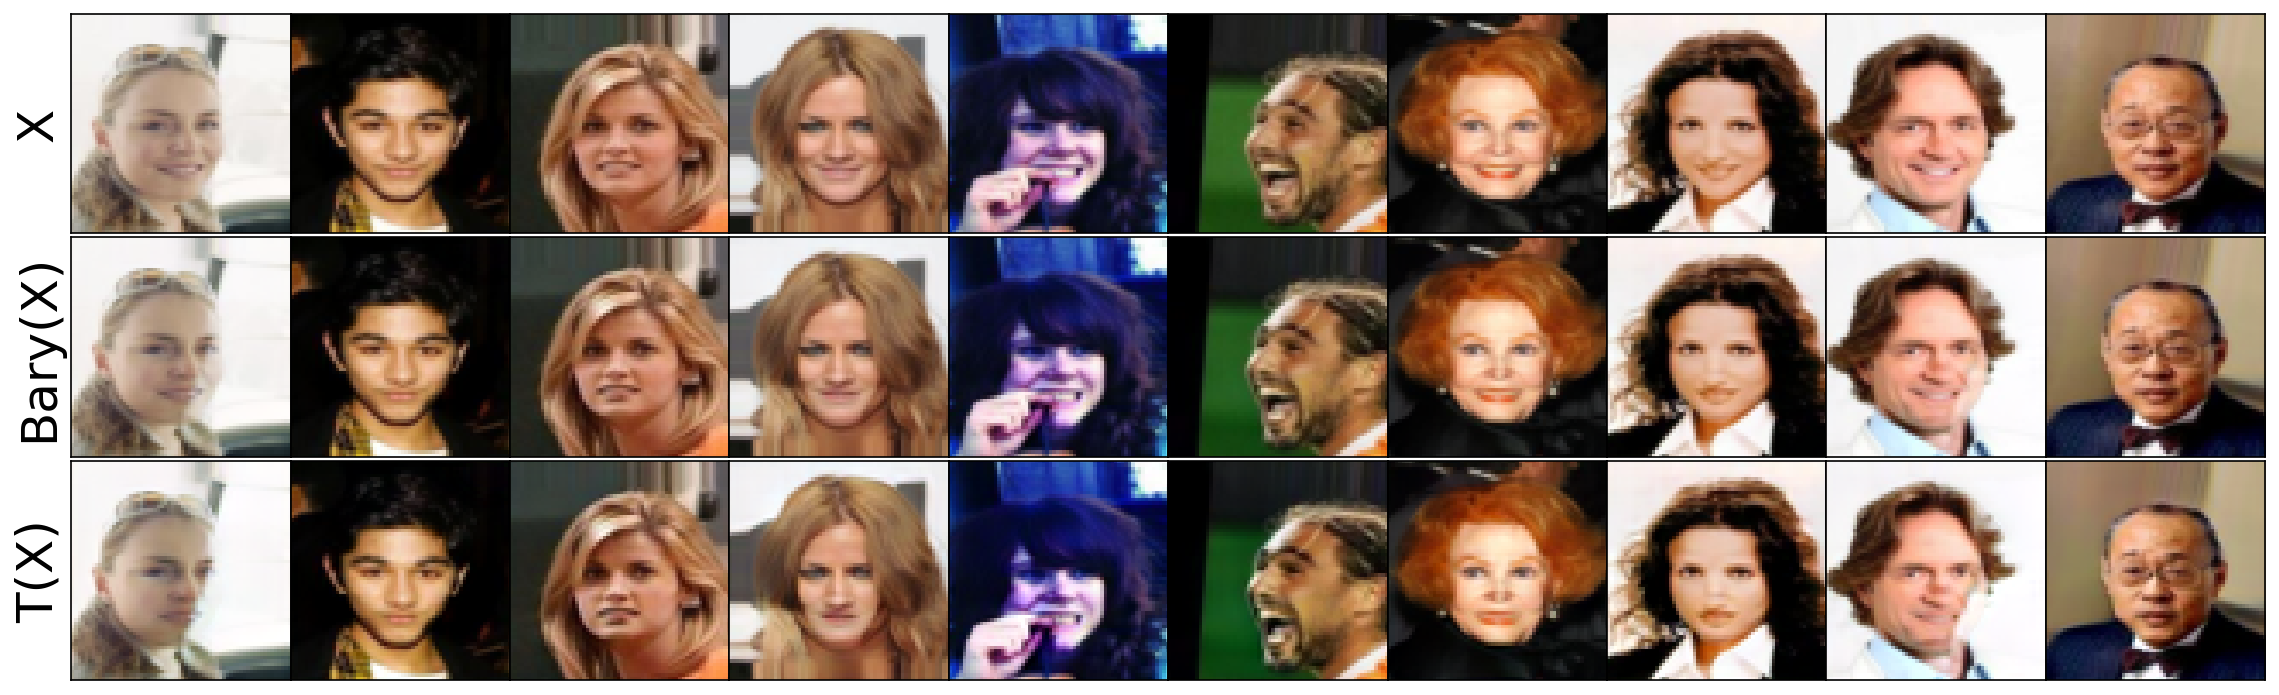

In [266]:
fig, axes = plot_images(X_fix, T)
plt.show(fig); plt.close(fig) 

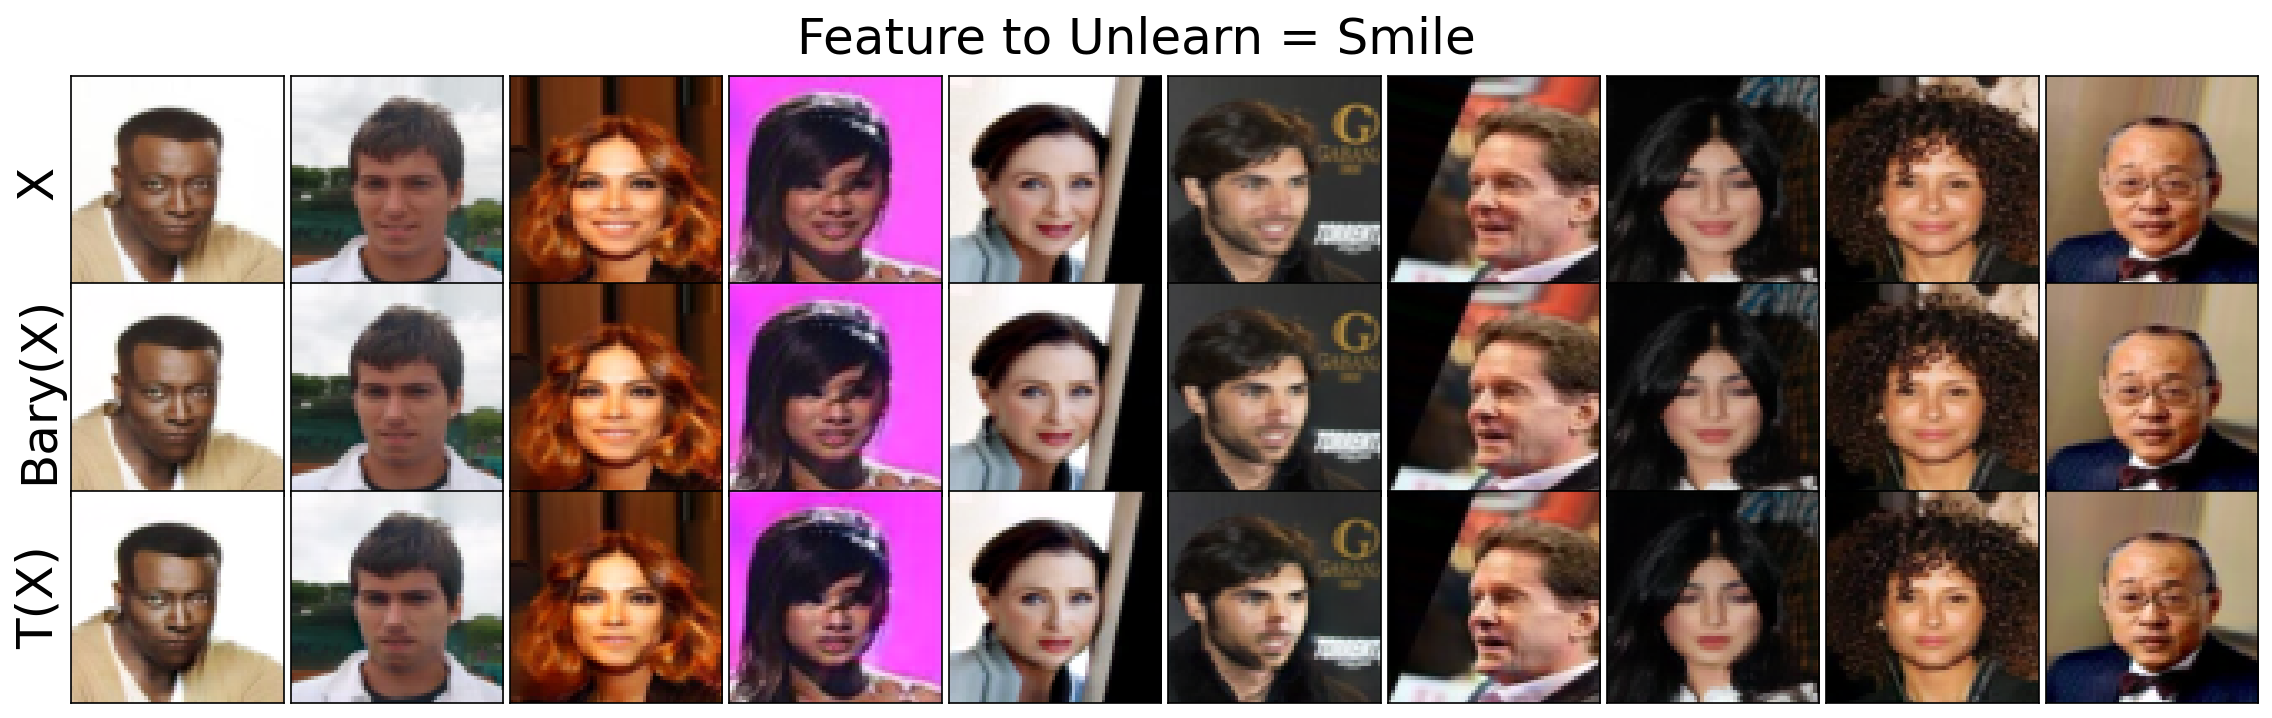

In [272]:
fig, axes = plot_images(X_fix_new, T)
plt.show(fig); plt.close(fig) 